In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
import warnings
import random
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score
from imblearn.over_sampling import RandomOverSampler
warnings.filterwarnings("ignore")
np.random.seed(0)
random.seed(0)

In [2]:
all_data = pd.read_csv('all_cleaned_data.csv')

### Defining key functions

#### DataFrame constructor

In [3]:
def degree_calculator(df):
    return df.shape[0]

def number_transacts_user(df):
    if df.shape[0]==0:
        return 0,0,0,0,0,0,0
    td = df.groupby('user')[['to']].count().reset_index()
    return td['to'].mean(), td['to'].std(), td['to'].median(),  td['to'].min(), np.quantile(td['to'], q=0.25), np.quantile(td['to'], q=0.75), td['to'].max()

def errors_calculator(df):
    if df.shape[0]==0:
        return 0,0,0,0,0,0
    return df['isError'].sum(), df['isError'].mean(), df['isError'].std(), df['isError'].median(), np.quantile(df['isError'], q=0.25), np.quantile(df['isError'], q=0.75)

def distinct_users(df):
    if df.shape[0]==0:
        return 0
    return df['user'].nunique()

def transaction_value(df):
    if df.shape[0]==0:
        return 0,0,0,0,0,0,0,0
    return df['Value_usd'].sum(), df['Value_usd'].mean(), df['Value_usd'].std(), df['Value_usd'].median(), df['Value_usd'].min(), np.quantile(df['Value_usd'], q=0.25), np.quantile(df['Value_usd'], q=0.75), df['Value_usd'].max()

def lifetime_calculator(df):
    return df['age_minutes'].mean(), df['age_minutes'].std(), df['age_minutes'].median(), np.quantile(df['age_minutes'], q=0.25), np.quantile(df['age_minutes'], q=0.75), df['age_minutes'].max()

def sign_calculator(row):
    if row['from']==row['user']:
        return -row['Value_usd']
    else:
        return row['Value_usd']

def inflows_from_users(df):
    td = df[df['value_correct_sign']<0]
    if td.shape[0]==0:
        return 0,0,0,0,0,0,0
    td = td.groupby('user')[['value_correct_sign']].sum().reset_index()
    return td['value_correct_sign'].mean(), td['value_correct_sign'].std(), td['value_correct_sign'].median(),  td['value_correct_sign'].min(), np.quantile(td['value_correct_sign'], q=0.25), np.quantile(td['value_correct_sign'], q=0.75), td['value_correct_sign'].max()

def outflows_to_users(df):
    td = df[df['value_correct_sign']>0]
    if td.shape[0]==0:
        return 0,0,0,0,0,0,0
    td = td.groupby('user')[['value_correct_sign']].sum().reset_index()
    return td['value_correct_sign'].mean(), td['value_correct_sign'].std(), td['value_correct_sign'].median(),  td['value_correct_sign'].min(), np.quantile(td['value_correct_sign'], q=0.25), np.quantile(td['value_correct_sign'], q=0.75), td['value_correct_sign'].max()

def transaction_costs_contract(df):
    if df.shape[0]==0:
        return 0,0,0,0,0,0,0,0
    return df['Transaction_cost_usd'].sum(), df['Transaction_cost_usd'].mean(), df['Transaction_cost_usd'].std(), df['Transaction_cost_usd'].median(), df['Transaction_cost_usd'].min(),np.quantile(df['Transaction_cost_usd'], q=0.25), np.quantile(df['Transaction_cost_usd'], q=0.75), df['Transaction_cost_usd'].max()

def transaction_costs_users(df):
    if df.shape[0]==0:
        return 0,0,0,0,0,0,0
    td = df.groupby('user')[['Transaction_cost_usd']].sum().reset_index()
    return td['Transaction_cost_usd'].mean(), td['Transaction_cost_usd'].std(), td['Transaction_cost_usd'].median(),  td['Transaction_cost_usd'].min(), np.quantile(td['Transaction_cost_usd'], q=0.25), np.quantile(td['Transaction_cost_usd'], q=0.75), td['Transaction_cost_usd'].max()

def apply_name(df):
    return [list(all_embeddings[df['contract_name'].iloc[0]])]

In [4]:
def contract_addresses(filtering_step, step):
    temp_df = contract_ntransacts[contract_ntransacts['n_transactions']>=filtering_step*step]
    return temp_df['contract_address'].tolist()

def dataframe_constructor(filtering_step, step,df):
    addresses = list(set(df['contract_address']))
    df['value_correct_sign'] = df.apply(sign_calculator, axis=1)
    #generic
    contract_list = []
    isponzi_list = []
    #degrees
    contract_in_degrees = []
    contract_out_degrees = []
    #number_transacts_users_indeg
    avg_number_transacts_users_indeg =[]
    std_number_transacts_users_indeg = []
    median_number_transacts_users_indeg = []
    min_number_transacts_users_indeg = []
    q1_number_transacts_users_indeg = []
    q3_number_transacts_users_indeg = []
    max_number_transacts_users_indeg = []
    #number_transacts_users_outdeg
    avg_number_transacts_users_outdeg =[]
    std_number_transacts_users_outdeg = []
    median_number_transacts_users_outdeg = []
    min_number_transacts_users_outdeg = []
    q1_number_transacts_users_outdeg = []
    q3_number_transacts_users_outdeg = []
    max_number_transacts_users_outdeg = []
    #errors_indeg
    total_errors_indeg=[]
    avg_errors_indeg =[]
    std_errors_indeg = []
    median_errors_indeg = []
    q1_errors_indeg = []
    q3_errors_indeg = []
    #errors_outdeg
    total_errors_outdeg=[]
    avg_errors_outdeg =[]
    std_errors_outdeg = []
    median_errors_outdeg = []
    q1_errors_outdeg = []
    q3_errors_outdeg = []
    #distinct_users
    distinct_users_indeg=[]
    distinct_users_outdeg=[]
    #transaction_value_indeg
    total_value_indeg=[]
    avg_value_indeg =[]
    std_value_indeg = []
    median_value_indeg = []
    min_value_indeg = []
    q1_value_indeg = []
    q3_value_indeg = []
    max_value_indeg = []
    #transaction_value_outdeg
    total_value_outdeg=[]
    avg_value_outdeg =[]
    std_value_outdeg = []
    median_value_outdeg = []
    min_value_outdeg = []
    q1_value_outdeg = []
    q3_value_outdeg = []
    max_value_outdeg = []
    #age_minutes
    avg_age_minutes =[]
    std_age_minutes = []
    median_age_minutes = []
    q1_age_minutes = []
    q3_age_minutes = []
    max_age_minutes = []
    #inflows_from_users
    avg_inflows_from_users =[]
    std_inflows_from_users = []
    median_inflows_from_users = []
    min_inflows_from_users = []
    q1_inflows_from_users = []
    q3_inflows_from_users = []
    max_inflows_from_users = []
    #outflows_from_users
    avg_outflows_from_users =[]
    std_outflows_from_users = []
    median_outflows_from_users = []
    min_outflows_from_users = []
    q1_outflows_from_users = []
    q3_outflows_from_users = []
    max_outflows_from_users = []
    #transaction_costs_contract
    total_transaction_costs_contract=[]
    avg_transaction_costs_contract =[]
    std_transaction_costs_contract = []
    median_transaction_costs_contract = []
    min_transaction_costs_contract = []
    q1_transaction_costs_contract = []
    q3_transaction_costs_contract = []
    max_transaction_costs_contract = []
    #transaction_costs_users
    avg_transaction_costs_users =[]
    std_transaction_costs_users = []
    median_transaction_costs_users = []
    min_transaction_costs_users = []
    q1_transaction_costs_users = []
    q3_transaction_costs_users = []
    max_transaction_costs_users = []
    #name_embedding
    #name_embedding=[]
    dummy_clust_0 = []
    dummy_clust_1 = []
    dummy_clust_2 = []
    dummy_clust_3 = []
    dummy_clust_4 = []
    dummy_clust_5 = []

    for contract in tqdm(addresses):
        #generic
        contract_list.append(contract)
        temp_df = df[df['contract_address']==contract].sort_values('Date').head(filtering_step*step)
        isponzi_list.append(temp_df['is_ponzi'].iloc[0])
        temp_df_internal = temp_df[temp_df['isinternal']==1]
        temp_df_external = temp_df[temp_df['isinternal']==0]
        #degrees
        contract_in_degrees.append(degree_calculator(temp_df_external))
        contract_out_degrees.append(degree_calculator(temp_df_internal))
        #number_transacts_users_indeg
        avg_numb, std_numb, median_numb, min_numb, q1_numb, q3_numb, max_numb = number_transacts_user(temp_df_external)
        avg_number_transacts_users_indeg.append(avg_numb)
        std_number_transacts_users_indeg.append(std_numb)
        median_number_transacts_users_indeg.append(median_numb)
        min_number_transacts_users_indeg.append(min_numb)
        q1_number_transacts_users_indeg.append(q1_numb)
        q3_number_transacts_users_indeg.append(q3_numb)
        max_number_transacts_users_indeg.append(max_numb)
        #number_transacts_users_outdeg
        avg_numb, std_numb, median_numb, min_numb, q1_numb, q3_numb, max_numb = number_transacts_user(temp_df_internal)
        avg_number_transacts_users_outdeg.append(avg_numb)
        std_number_transacts_users_outdeg.append(std_numb)
        median_number_transacts_users_outdeg.append(median_numb)
        min_number_transacts_users_outdeg.append(min_numb)
        q1_number_transacts_users_outdeg.append(q1_numb)
        q3_number_transacts_users_outdeg.append(q3_numb)
        max_number_transacts_users_outdeg.append(max_numb)
        #errors_indeg
        total_numb,avg_numb, std_numb, median_numb, q1_numb, q3_numb = errors_calculator(temp_df_external)
        total_errors_indeg.append(total_numb)
        avg_errors_indeg.append(avg_numb)
        std_errors_indeg.append(std_numb)
        median_errors_indeg.append(median_numb)
        q1_errors_indeg.append(q1_numb)
        q3_errors_indeg.append(q3_numb)
        #errors_outdeg
        total_numb,avg_numb, std_numb, median_numb, q1_numb, q3_numb = errors_calculator(temp_df_internal)
        total_errors_outdeg.append(total_numb)
        avg_errors_outdeg.append(avg_numb)
        std_errors_outdeg.append(std_numb)
        median_errors_outdeg.append(median_numb)
        q1_errors_outdeg.append(q1_numb)
        q3_errors_outdeg.append(q3_numb)
        #distinct_users
        distinct_users_indeg.append(distinct_users(temp_df_external))
        distinct_users_outdeg.append(distinct_users(temp_df_internal))
        #transaction_value_indeg
        total_numb,avg_numb, std_numb, median_numb, min_numb, q1_numb, q3_numb, max_numb = transaction_value(temp_df_external)
        total_value_indeg.append(total_numb)
        avg_value_indeg.append(avg_numb)
        std_value_indeg.append(std_numb)
        median_value_indeg.append(median_numb)
        min_value_indeg.append(min_numb)
        q1_value_indeg.append(q1_numb)
        q3_value_indeg.append(q3_numb)
        max_value_indeg.append(max_numb)
        #transaction_value_outdeg
        total_numb,avg_numb, std_numb, median_numb, min_numb, q1_numb, q3_numb, max_numb = transaction_value(temp_df_internal)
        total_value_outdeg.append(total_numb)
        avg_value_outdeg.append(avg_numb)
        std_value_outdeg.append(std_numb)
        median_value_outdeg.append(median_numb)
        min_value_outdeg.append(min_numb)
        q1_value_outdeg.append(q1_numb)
        q3_value_outdeg.append(q3_numb)
        max_value_outdeg.append(max_numb)
        #age_minutes
        avg_numb, std_numb, median_numb, q1_numb, q3_numb, max_numb = lifetime_calculator(temp_df)
        avg_age_minutes.append(avg_numb)
        std_age_minutes.append(std_numb)
        median_age_minutes.append(median_numb)
        q1_age_minutes.append(q1_numb)
        q3_age_minutes.append(q3_numb)
        max_age_minutes.append(max_numb)
        #inflows_from_users
        avg_numb, std_numb, median_numb, min_numb, q1_numb, q3_numb, max_numb = inflows_from_users(temp_df_external)
        avg_inflows_from_users.append(avg_numb)
        std_inflows_from_users.append(std_numb)
        median_inflows_from_users.append(median_numb)
        min_inflows_from_users.append(min_numb)
        q1_inflows_from_users.append(q1_numb)
        q3_inflows_from_users.append(q3_numb)
        max_inflows_from_users.append(max_numb)
        #outflows_from_users
        avg_numb, std_numb, median_numb, min_numb, q1_numb, q3_numb, max_numb = outflows_to_users(temp_df_internal)
        avg_outflows_from_users.append(avg_numb)
        std_outflows_from_users.append(std_numb)
        median_outflows_from_users.append(median_numb)
        min_outflows_from_users.append(min_numb)
        q1_outflows_from_users.append(q1_numb)
        q3_outflows_from_users.append(q3_numb)
        max_outflows_from_users.append(max_numb)
        #transaction_costs_contract
        total_numb,avg_numb, std_numb, median_numb, min_numb, q1_numb, q3_numb, max_numb = transaction_costs_contract(temp_df_internal)
        total_transaction_costs_contract.append(total_numb)
        avg_transaction_costs_contract.append(avg_numb)
        std_transaction_costs_contract.append(std_numb)
        median_transaction_costs_contract.append(median_numb)
        min_transaction_costs_contract.append(min_numb)
        q1_transaction_costs_contract.append(q1_numb)
        q3_transaction_costs_contract.append(q3_numb)
        max_transaction_costs_contract.append(max_numb)
        #transaction_costs_users
        avg_numb, std_numb, median_numb, min_numb, q1_numb, q3_numb, max_numb = transaction_costs_users(temp_df_external)
        avg_transaction_costs_users.append(avg_numb)
        std_transaction_costs_users.append(std_numb)
        median_transaction_costs_users.append(median_numb)
        min_transaction_costs_users.append(min_numb)
        q1_transaction_costs_users.append(q1_numb)
        q3_transaction_costs_users.append(q3_numb)
        max_transaction_costs_users.append(max_numb)
        #name_embedding
        dummy_clust_0.append(temp_df['cluster_0.0'].iloc[0])
        dummy_clust_1.append(temp_df['cluster_1.0'].iloc[0])
        dummy_clust_2.append(temp_df['cluster_2.0'].iloc[0])
        dummy_clust_3.append(temp_df['cluster_3.0'].iloc[0])
        dummy_clust_4.append(temp_df['cluster_4.0'].iloc[0])
        dummy_clust_5.append(temp_df['cluster_5.0'].iloc[0])
        #name_embedding.append(apply_name(temp_df))

    dataframe = pd.DataFrame({
        'isponzi':isponzi_list, 
        'contract_id':contract_list,
        'contract_in_degrees':contract_in_degrees, 
        'contract_out_degrees':contract_out_degrees, 
        'avg_number_transacts_users_indeg':avg_number_transacts_users_indeg,
        'std_number_transacts_users_indeg': std_number_transacts_users_indeg,
        'median_number_transacts_users_indeg': median_number_transacts_users_indeg,
        'min_number_transacts_users_indeg': min_number_transacts_users_indeg,
        'q1_number_transacts_users_indeg': q1_number_transacts_users_indeg,
        'q3_number_transacts_users_indeg': q3_number_transacts_users_indeg,
        'max_number_transacts_users_indeg': max_number_transacts_users_indeg,
        'avg_number_transacts_users_outdeg': avg_number_transacts_users_outdeg,
        'std_number_transacts_users_outdeg': std_number_transacts_users_outdeg,
        'median_number_transacts_users_outdeg': median_number_transacts_users_outdeg,
        'min_number_transacts_users_outdeg': min_number_transacts_users_outdeg,
        'q1_number_transacts_users_outdeg': q1_number_transacts_users_outdeg,
        'q3_number_transacts_users_outdeg': q3_number_transacts_users_outdeg,
        'max_number_transacts_users_outdeg': max_number_transacts_users_outdeg,
        'total_errors_indeg':total_errors_indeg,
        'avg_errors_indeg': avg_errors_indeg,
        'std_errors_indeg': std_errors_indeg,
        'median_errors_indeg': median_errors_indeg,
        'q1_errors_indeg': q1_errors_indeg,
        'q3_errors_indeg': q3_errors_indeg,
        'total_errors_outdeg': total_errors_outdeg,
        'avg_errors_outdeg': avg_errors_outdeg, 
        'std_errors_outdeg': std_errors_outdeg, 
        'median_errors_outdeg': median_errors_outdeg, 
        'q1_errors_outdeg': q1_errors_outdeg, 
        'q3_errors_outdeg': q3_errors_outdeg, 
        'distinct_users_indeg': distinct_users_indeg,
        'distinct_users_outdeg': distinct_users_outdeg,
        'total_value_indeg': total_value_indeg,
        'avg_value_indeg': avg_value_indeg, 
        'std_value_indeg': std_value_indeg, 
        'median_value_indeg': median_value_indeg, 
        'min_value_indeg': min_value_indeg, 
        'q1_value_indeg': q1_value_indeg, 
        'q3_value_indeg': q3_value_indeg, 
        'max_value_indeg': max_value_indeg, 
        'total_value_outdeg': total_value_outdeg,
        'avg_value_outdeg': avg_value_outdeg,
        'std_value_outdeg': std_value_outdeg,
        'median_value_outdeg': median_value_outdeg,
        'min_value_outdeg': min_value_outdeg,
        'q1_value_outdeg': q1_value_outdeg,
        'q3_value_outdeg': q3_value_outdeg,
        'max_value_outdeg': max_value_outdeg,
        'avg_age_minutes': avg_age_minutes, 
        'std_age_minutes': std_age_minutes, 
        'median_age_minutes': median_age_minutes, 
        'q1_age_minutes': q1_age_minutes, 
        'q3_age_minutes': q3_age_minutes, 
        'max_age_minutes': max_age_minutes, 
        'avg_inflows_from_users': avg_inflows_from_users, 
        'std_inflows_from_users': std_inflows_from_users, 
        'median_inflows_from_users': median_inflows_from_users, 
        'min_inflows_from_users': min_inflows_from_users, 
        'q1_inflows_from_users': q1_inflows_from_users, 
        'q3_inflows_from_users': q3_inflows_from_users, 
        'max_inflows_from_users': max_inflows_from_users, 
        'avg_outflows_from_users': avg_outflows_from_users, 
        'std_outflows_from_users': std_outflows_from_users, 
        'median_outflows_from_users': median_outflows_from_users, 
        'min_outflows_from_users': min_outflows_from_users, 
        'q1_outflows_from_users': q1_outflows_from_users, 
        'q3_outflows_from_users': q3_outflows_from_users, 
        'max_outflows_from_users': max_outflows_from_users, 
        'total_transaction_costs_contract': total_transaction_costs_contract,
        'avg_transaction_costs_contract': avg_transaction_costs_contract, 
        'std_transaction_costs_contract': std_transaction_costs_contract, 
        'median_transaction_costs_contract': median_transaction_costs_contract, 
        'min_transaction_costs_contract': min_transaction_costs_contract, 
        'q1_transaction_costs_contract': q1_transaction_costs_contract, 
        'q3_transaction_costs_contract': q3_transaction_costs_contract, 
        'max_transaction_costs_contract': max_transaction_costs_contract, 
        'avg_transaction_costs_users': avg_transaction_costs_users, 
        'std_transaction_costs_users': std_transaction_costs_users, 
        'median_transaction_costs_users': median_transaction_costs_users, 
        'min_transaction_costs_users': min_transaction_costs_users, 
        'q1_transaction_costs_users': q1_transaction_costs_users, 
        'q3_transaction_costs_users': q3_transaction_costs_users, 
        'max_transaction_costs_users': max_transaction_costs_users,
        'dummy_clust_0':dummy_clust_0,
        'dummy_clust_1':dummy_clust_1,
        'dummy_clust_2':dummy_clust_2,
        'dummy_clust_3':dummy_clust_3,
        'dummy_clust_4':dummy_clust_4,
        'dummy_clust_5':dummy_clust_5
        #'name_embedding': name_embedding
    })
    return dataframe

#### Model fitting functions

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
scoring=['recall','precision' , 'roc_auc', 'f1']

def optimize_model(model, param_dist, tr_s, y_tr):
    search = GridSearchCV(model,
                param_grid=param_dist,
                scoring=scoring,
                refit='f1',
                cv=5,
                n_jobs=-1,
                verbose=0,
                error_score='raise')

    search.fit(tr_s, y_tr)
    scoring_metrics = {}
    for metric in scoring:
        scoring_metrics[metric] =  search.cv_results_['mean_test_'+metric][search.best_index_]
    return search.best_estimator_, scoring_metrics

In [6]:
def logistic_model(train_data):
    param_dist = {'class_weight':['balanced', None]}
    model=LogisticRegression(penalty='none')
    return optimize_model(model, param_dist, train_data.iloc[:, 2:], train_data.iloc[:, 0])

def elastic_net_model(train_data): 
    param_dist = {'alpha':np.arange(1, 21, 2), 'l1_ratio':np.arange(0, 1, 0.2), 'class_weight':['balanced', None]}
    model=SGDClassifier(penalty='elasticnet', loss='modified_huber', shuffle=False, max_iter=2000, learning_rate='adaptive', eta0=0.01)
    return optimize_model(model, param_dist, train_data.iloc[:, 2:], train_data.iloc[:, 0])

def gradient_boosting_model(train_data): 
    param_dist = {"n_estimators": np.arange(100, 2000, 100), 'max_depth':np.arange(2, 10)}
    model = GradientBoostingClassifier(max_features='sqrt', loss='exponential')
    return optimize_model(model, param_dist, train_data.iloc[:, 2:], train_data.iloc[:, 0])

def random_forest_model(train_data): 
    depths=np.arange(2,10).tolist()
    param_dist = {"n_estimators": np.arange(100, 1000, 100), 'max_depth':depths, 'class_weight':[None, 'balanced']}
    model = RandomForestClassifier(max_features='sqrt', n_jobs=-1)
    return optimize_model(model, param_dist, train_data.iloc[:, 2:], train_data.iloc[:, 0])
 
def svm_model(train_data):
     param_dist = {'kernel':['poly','rbf', 'sigmoid'], 'C':np.arange(0.01,5.01,0.2), 'class_weight':[None, 'balanced']}
     model = SVC()
     return optimize_model(model, param_dist, train_data.iloc[:, 2:], train_data.iloc[:, 0])

def mlrp_model(train_data): 
    param_dist = {'hidden_layer_sizes': [(100, 50, 20, 10), (100, 100, 50, 50, 20, 20, 10, 10), 
                                    (50, 50, 50, 50, 20, 20, 10), (20, 20, 20, 10, 10), (10,10,5,5), (100)],
              'activation':['relu', 'logistic'],'alpha':np.arange(0.01, 20.01, 2)}
    model = MLPClassifier(max_iter=1500)
    return optimize_model(model, param_dist, train_data.iloc[:, 2:], train_data.iloc[:, 0])

def stacking_model(train_data,models_dict):
    param_dist = {'final_estimator__l1_ratio':np.arange(0, 1.5, 0.5)}
    model_list=[(k,v) for k,v in models_dict.items()]
    level1 = SGDClassifier(max_iter=1000) 
    model = StackingClassifier(estimators=model_list, final_estimator=level1)
    return optimize_model(model, param_dist, train_data.iloc[:, 2:], train_data.iloc[:, 0])

In [7]:
def importances_plotter(gradient_boosting, random_forest):
    #fig, axs = plt.subplots(ncols=2, figsize=(17,6))
    #ax=axs[0]
    importances_df = pd.DataFrame({'Feature name':gradient_boosting.feature_names_in_, 'Feature importance':gradient_boosting.feature_importances_})
    importances_df['Feature importance']/=importances_df['Feature importance'].max()
    importances_df = importances_df.sort_values('Feature importance', ascending=False)
    #importances_df.head(15).plot.bar(x='Feature name', y='Feature importance', color='blue', ax=ax)
    #ax.get_legend().remove()
    #ax.set_xticklabels(importances_df.head(15)['Feature name'], rotation=45, ha='right')
    #ax.set_title('Top 15 most important features Gradient Boosting')
    boosting_importances = importances_df.copy()
    #RF
    #ax=axs[1]
    importances_df = pd.DataFrame({'Feature name':random_forest.feature_names_in_, 'Feature importance':random_forest.feature_importances_})
    importances_df['Feature importance']/=importances_df['Feature importance'].max()
    importances_df = importances_df.sort_values('Feature importance', ascending=False)
    #importances_df.head(15).plot.bar(x='Feature name', y='Feature importance', color='blue', ax=ax)
    #ax.get_legend().remove()
    #ax.set_xticklabels(importances_df.head(15)['Feature name'], rotation=45, ha='right')
    #ax.set_title('Top 15 most important features Random Forest')
    rf_importances = importances_df.copy()
    #plt.show()
    return boosting_importances, rf_importances

In [8]:
def metrics_plotter(dummy, elastic_net, gradient_boosting, random_forest, svm, mlrp,stacking):
    fig, axs = plt.subplots(nrows =2, ncols=2, figsize=(25,20))
    ax = axs[0,0]
    ax.set_title('Recall scores')
    ax.bar(x='dummy', height=dummy['recall'], color='blue')
    ax.bar(x='elastic_net', height=elastic_net['recall'], color='blue')
    ax.bar(x='gradient_boosting', height=gradient_boosting['recall'], color='blue')
    ax.bar(x='random_forest', height=random_forest['recall'], color='blue')
    ax.bar(x='svm', height=svm['recall'], color='blue')
    ax.bar(x='mlrp', height=mlrp['recall'], color='blue')
    ax.bar(x='stacking', height=stacking['recall'], color='blue')
    ax.set_xticklabels(['dummy','elastic_net','gradient_boosting','random_forest','svm', 'mlrp','stacking'], rotation=45, ha='right')
    
    ax=axs[0,1]
    ax.set_title('Precision scores')
    ax.bar(x='dummy', height=dummy['precision'], color='blue')
    ax.bar(x='elastic_net', height=elastic_net['precision'], color='blue')
    ax.bar(x='gradient_boosting', height=gradient_boosting['precision'], color='blue')
    ax.bar(x='random_forest', height=random_forest['precision'], color='blue')
    ax.bar(x='svm', height=svm['precision'], color='blue')
    ax.bar(x='mlrp', height=mlrp['precision'], color='blue')
    ax.bar(x='stacking', height=stacking['precision'], color='blue')
    ax.set_xticklabels(['dummy','elastic_net','gradient_boosting','random_forest','svm', 'mlrp','stacking'], rotation=45, ha='right')

    ax=axs[1,0]
    ax.set_title('Auroc scores')
    ax.bar(x='dummy', height=dummy['roc_auc'], color='blue')
    ax.bar(x='elastic_net', height=elastic_net['roc_auc'], color='blue')
    ax.bar(x='gradient_boosting', height=gradient_boosting['roc_auc'], color='blue')
    ax.bar(x='random_forest', height=random_forest['roc_auc'], color='blue')
    ax.bar(x='svm', height=svm['roc_auc'], color='blue')
    ax.bar(x='mlrp', height=mlrp['roc_auc'], color='blue')
    ax.bar(x='stacking', height=stacking['roc_auc'], color='blue')
    ax.set_xticklabels(['dummy','elastic_net','gradient_boosting','random_forest','svm', 'mlrp','stacking'], rotation=45, ha='right')

    ax = axs[1,1]
    ax.set_title('F1 macro scores')
    ax.bar(x='dummy', height=dummy['f1'], color='blue')
    ax.bar(x='elastic_net', height=elastic_net['f1'], color='blue')
    ax.bar(x='gradient_boosting', height=gradient_boosting['f1'], color='blue')
    ax.bar(x='random_forest', height=random_forest['f1'], color='blue')
    ax.bar(x='svm', height=svm['f1'], color='blue')
    ax.bar(x='mlrp', height=mlrp['f1'], color='blue')
    ax.bar(x='stacking', height=stacking['f1'], color='blue')
    ax.set_xticklabels(['dummy','elastic_net','gradient_boosting','random_forest','svm', 'mlrp','stacking'], rotation=45, ha='right')
    plt.show()

In [9]:
def fitting_step_training(train_data):
    optimal_models = {}
    logistic_classifier, logistic_metrics = logistic_model(train_data)
    elastic_net_classifier, elastic_net_metrics = elastic_net_model(train_data)
    optimal_models['ElasticNet'] = elastic_net_classifier
    gradient_boosting_classifier, gradient_boosting_metrics = gradient_boosting_model(train_data)
    optimal_models['GradientBoosting'] = gradient_boosting_classifier
    random_forest_classifier, random_forest_metrics = random_forest_model(train_data)
    optimal_models['RandomForest'] = random_forest_classifier
    svm_classifier, svm_metrics = svm_model(train_data)
    optimal_models['SVM'] = svm_classifier
    mlrp_classifier, mlrp_metrics = mlrp_model(train_data)
    optimal_models['MLRP'] = mlrp_classifier
    stacking_classifier, stacking_metrics = stacking_model(train_data, optimal_models)
    optimal_models['Stacking'] = stacking_classifier
    boosting_importances, rf_importances = importances_plotter(gradient_boosting_classifier, random_forest_classifier)
    return logistic_classifier, elastic_net_classifier, gradient_boosting_classifier, random_forest_classifier, svm_classifier, mlrp_classifier,stacking_classifier, boosting_importances, rf_importances

In [10]:
def compute_test_metrics(y_true, y_pred):
    return {'recall':recall_score(y_true, y_pred),
            'precision':precision_score(y_true, y_pred),
            'roc_auc':roc_auc_score(y_true, y_pred),
            'f1':f1_score(y_true, y_pred)}

def fitting_step_test(test_data, logistic, elastic_net, gradient_boosting, random_forest, svm, mlrp,stacking):
    preds = logistic.predict(test_data.iloc[:, 2:])
    logistic_metrics = compute_test_metrics(test_data.iloc[:, 0], preds)
    preds = elastic_net.predict(test_data.iloc[:, 2:])
    elastic_net_metrics = compute_test_metrics(test_data.iloc[:, 0], preds)
    preds = gradient_boosting.predict(test_data.iloc[:, 2:])
    gradient_boosting_metrics = compute_test_metrics(test_data.iloc[:, 0], preds)
    preds = random_forest.predict(test_data.iloc[:, 2:])
    random_forest_metrics = compute_test_metrics(test_data.iloc[:, 0], preds)
    preds = svm.predict(test_data.iloc[:, 2:])
    svm_metrics = compute_test_metrics(test_data.iloc[:, 0], preds)
    preds = mlrp.predict(test_data.iloc[:, 2:])
    mlrp_metrics = compute_test_metrics(test_data.iloc[:, 0], preds)
    preds = stacking.predict(test_data.iloc[:, 2:])
    stacking_metrics = compute_test_metrics(test_data.iloc[:, 0], preds)
    #metrics_plotter(logistic_metrics, elastic_net_metrics, gradient_boosting_metrics, random_forest_metrics, svm_metrics, mlrp_metrics,stacking_metrics)
    return logistic_metrics, elastic_net_metrics, gradient_boosting_metrics, random_forest_metrics, svm_metrics, mlrp_metrics,stacking_metrics

In [11]:
def do_5_runs(train_df, test_df, step, metrics_df_current=pd.DataFrame(), rf_importances_current=pd.DataFrame(), boosting_importances_current=pd.DataFrame()):
    metrics_df_boots = pd.DataFrame()
    boosting_importances_boost = pd.DataFrame()
    rf_importances_boost = pd.DataFrame()
    for i in tqdm(range(5)):
        np.random.seed(i)
        random.seed(i)
        ros = RandomOverSampler(random_state=i, sampling_strategy='minority')
        train_df_sample = train_df.copy()
        X_resampled, y_resampled = ros.fit_resample(train_df_sample.iloc[:,2:], train_df_sample['isponzi'])
        train_df_sample = pd.DataFrame(y_resampled)
        train_df_sample['contract_address']=0
        train_df_sample = pd.concat([train_df_sample, X_resampled], axis=1)
        logistic_classifier, elastic_net_classifier, gradient_boosting_classifier, random_forest_classifier, svm_classifier, mlrp_classifier,stacking_classifier,boosting_importances1, rf_importances1 = fitting_step_training(train_df_sample)
        logistic_metrics, elastic_net_metrics, gradient_boosting_metrics, random_forest_metrics, svm_metrics, mlrp_metrics,stacking_metrics = fitting_step_test(test_df, logistic_classifier, elastic_net_classifier, gradient_boosting_classifier, random_forest_classifier, svm_classifier, mlrp_classifier,stacking_classifier)
        metrics_df = pd.DataFrame(logistic_metrics, index=[0])
        metrics_df.loc[len(metrics_df.index)] = elastic_net_metrics
        metrics_df.loc[len(metrics_df.index)] = gradient_boosting_metrics
        metrics_df.loc[len(metrics_df.index)] = random_forest_metrics
        metrics_df.loc[len(metrics_df.index)] = svm_metrics
        metrics_df.loc[len(metrics_df.index)] = mlrp_metrics
        metrics_df.loc[len(metrics_df.index)] = stacking_metrics
        metrics_df['model']=['Logistic', 'ElasticNet', 'GradientBoosting', 'RandomForest', 'SVM', 'MLRP', 'Stacking']
        metrics_df['step']=step
        metrics_df = metrics_df.reset_index(drop=True)
        metrics_df_boots=pd.concat([metrics_df_boots, metrics_df], axis=0)
        boosting_importances_boost = pd.concat([boosting_importances_boost, boosting_importances1], axis=0)
        rf_importances_boost = pd.concat([rf_importances_boost, rf_importances1], axis=0)

    metrics_df_mean = metrics_df_boots.groupby(['model', 'step']).mean().reset_index()
    rf_importances_boost = rf_importances_boost.groupby('Feature name')[['Feature importance']].mean().reset_index()
    boosting_importances_boost = boosting_importances_boost.groupby('Feature name')[['Feature importance']].mean().reset_index()
    if metrics_df_current.shape[0]==0:
        metrics_df_mean.to_csv('Final_metrics_10_runs/metrics_ml_mean_random_oversampling.csv', index=False)
        rf_importances_boost.to_csv('Final_metrics_10_runs/rf_importances_mean_random_oversampling.csv', index=False)
        boosting_importances_boost.to_csv('Final_metrics_10_runs/boosting_importances_mean_random_oversampling.csv', index=False)
        return metrics_df_mean, rf_importances_boost, boosting_importances_boost
    else:
        metrics_df_current=pd.concat([metrics_df_current, metrics_df_mean], axis=0)
        rf_importances_current=pd.concat([rf_importances_current, rf_importances_boost], axis=0)
        boosting_importances_current=pd.concat([boosting_importances_current, boosting_importances_boost], axis=0)
        metrics_df_current.to_csv('Final_metrics_10_runs/metrics_ml_mean_random_oversampling.csv', index=False)
        rf_importances_current.to_csv('Final_metrics_10_runs/rf_importances_mean_random_oversampling.csv', index=False)
        boosting_importances_current.to_csv('Final_metrics_10_runs/boosting_importances_mean_random_oversampling.csv', index=False)
        return metrics_df_current, rf_importances_current, boosting_importances_current

## Step 1

#### Generating data

In [12]:
contract_ntransacts = all_data.groupby('contract_address')[['Date']].count().reset_index().rename({'Date':'n_transactions'}, axis=1)
addresses_step = contract_addresses(10,1)
addresses_step = all_data[all_data['contract_address'].isin(addresses_step)][['contract_address', 'is_ponzi']].drop_duplicates('contract_address').reset_index(drop=True)
addresses_step = addresses_step.sample(frac=1).reset_index()
addresses_step.head()

,index,contract_address,is_ponzi
0,937,0x6695ff9ef4a5482b89b53b57462f7030ce58ce6a,0
1,182,0xdd97853ba34af302f3d6a6415a750ae38e26d1fc,1
2,1342,0xa0264dc5b89692dde2315090a35bed2ba15508b4,0
3,1993,0xf8eb1928b7b247e5ab607785afe869d7daf78a6f,0
4,1982,0xf7dca20054469a1d548b20859a100b9ec6ff1f61,0


In [13]:
train_df, test_df = train_test_split(addresses_step, test_size=0.25,random_state=42, stratify=addresses_step['is_ponzi'])
print('Total number of Ponzi schemes available for the step:', addresses_step['is_ponzi'].sum())
print('\n--- Training ---\n')
print('Percentage of Ponzi in training', np.round(100*train_df['is_ponzi'].sum()/addresses_step['is_ponzi'].sum(),2), 'corresponding to', train_df['is_ponzi'].sum(), 'smart contracts')
print('Fraction of Ponzi in training dataset:', np.round(100*train_df['is_ponzi'].sum()/train_df.shape[0], 2))
print('\n--- Testing ---\n')
print('Percentage of Ponzi in test', np.round(100*test_df['is_ponzi'].sum()/addresses_step['is_ponzi'].sum(),2), 'corresponding to', test_df['is_ponzi'].sum(), 'smart contracts')
print('Fraction of Ponzi in testing dataset:', np.round(100*test_df['is_ponzi'].sum()/test_df.shape[0], 2))

Total number of Ponzi schemes available for the step: 222

--- Training ---

Percentage of Ponzi in training 75.23 corresponding to 167 smart contracts
Fraction of Ponzi in training dataset: 10.94

--- Testing ---

Percentage of Ponzi in test 24.77 corresponding to 55 smart contracts
Fraction of Ponzi in testing dataset: 10.81


In [14]:
train_df = dataframe_constructor(10, 1, all_data[all_data['contract_address'].isin(train_df['contract_address'])].reset_index(drop=True))
test_df = dataframe_constructor(10, 1, all_data[all_data['contract_address'].isin(test_df['contract_address'])].reset_index(drop=True))
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)


100%|██████████| 509/509 [00:32<00:00, 15.61it/s]


#### Model Fitting

In [15]:
df_metrics, df_rf_importances, df_boosting_importances = do_5_runs(train_df, test_df, 1)

100%|██████████| 5/5 [2:58:59<00:00, 2147.97s/it]  


## Step 2

#### Generating data

In [16]:
contract_ntransacts = all_data.groupby('contract_address')[['Date']].count().reset_index().rename({'Date':'n_transactions'}, axis=1)
addresses_step = contract_addresses(10,2)
addresses_step = all_data[all_data['contract_address'].isin(addresses_step)][['contract_address', 'is_ponzi']].drop_duplicates('contract_address').reset_index(drop=True)
addresses_step = addresses_step.sample(frac=1).reset_index()
addresses_step.head()

,index,contract_address,is_ponzi
0,318,0x17df117bb806a622d841bd5166a23b5d8746232f,0
1,1243,0xb1eb96f752c624dc784d80961a1accfaf348c923,0
2,1602,0xea6278dbbe7cbb567e9e825d998c05432f0bdcf3,0
3,395,0x239de3a0d6ca5f21601f83327ea2174225eb7156,0
4,585,0x4490f9807965c49a2471bd7b121a80f0b3861e5c,0


In [17]:
train_df, test_df = train_test_split(addresses_step, test_size=0.25,random_state=42, stratify=addresses_step['is_ponzi'])
print('Total number of Ponzi schemes available for the step:', addresses_step['is_ponzi'].sum())
print('\n--- Training ---\n')
print('Percentage of Ponzi in training', np.round(100*train_df['is_ponzi'].sum()/addresses_step['is_ponzi'].sum(),2), 'corresponding to', train_df['is_ponzi'].sum(), 'smart contracts')
print('Fraction of Ponzi in training dataset:', np.round(100*train_df['is_ponzi'].sum()/train_df.shape[0], 2))
print('\n--- Testing ---\n')
print('Percentage of Ponzi in test', np.round(100*test_df['is_ponzi'].sum()/addresses_step['is_ponzi'].sum(),2), 'corresponding to', test_df['is_ponzi'].sum(), 'smart contracts')
print('Fraction of Ponzi in testing dataset:', np.round(100*test_df['is_ponzi'].sum()/test_df.shape[0], 2))

Total number of Ponzi schemes available for the step: 182

--- Training ---

Percentage of Ponzi in training 74.73 corresponding to 136 smart contracts
Fraction of Ponzi in training dataset: 10.56

--- Testing ---

Percentage of Ponzi in test 25.27 corresponding to 46 smart contracts
Fraction of Ponzi in testing dataset: 10.7


In [18]:
train_df = dataframe_constructor(10, 2, all_data[all_data['contract_address'].isin(train_df['contract_address'])].reset_index(drop=True))
test_df = dataframe_constructor(10, 2, all_data[all_data['contract_address'].isin(test_df['contract_address'])].reset_index(drop=True))
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

100%|██████████| 430/430 [00:31<00:00, 13.77it/s]


#### Model Fitting

In [19]:
df_metrics, df_rf_importances, df_boosting_importances = do_5_runs(train_df, test_df, 2, df_metrics, df_rf_importances, df_boosting_importances)

100%|██████████| 5/5 [2:25:01<00:00, 1740.23s/it]


## Step 3

#### Generating data

In [20]:
contract_ntransacts = all_data.groupby('contract_address')[['Date']].count().reset_index().rename({'Date':'n_transactions'}, axis=1)
addresses_step = contract_addresses(10,3)
addresses_step = all_data[all_data['contract_address'].isin(addresses_step)][['contract_address', 'is_ponzi']].drop_duplicates('contract_address').reset_index(drop=True)
addresses_step = addresses_step.sample(frac=1).reset_index()
addresses_step.head()

,index,contract_address,is_ponzi
0,189,0x047055f35cb837e838dde0202b7b1a5a75757835,0
1,8,0x1170548c7bf8ff70e4f7d2829b5ac5aa19fe172e,1
2,514,0x4270bb238f6dd8b1c3ca01f96ca65b2647c06d3c,0
3,29,0x294308484f47ff5a833a284ac6949eb02728fbe4,1
4,1157,0xb626a5facc4de1c813f5293ec3be31979f1d1c78,0


In [21]:
train_df, test_df = train_test_split(addresses_step, test_size=0.25,random_state=42, stratify=addresses_step['is_ponzi'])
print('Total number of Ponzi schemes available for the step:', addresses_step['is_ponzi'].sum())
print('\n--- Training ---\n')
print('Percentage of Ponzi in training', np.round(100*train_df['is_ponzi'].sum()/addresses_step['is_ponzi'].sum(),2), 'corresponding to', train_df['is_ponzi'].sum(), 'smart contracts')
print('Fraction of Ponzi in training dataset:', np.round(100*train_df['is_ponzi'].sum()/train_df.shape[0], 2))
print('\n--- Testing ---\n')
print('Percentage of Ponzi in test', np.round(100*test_df['is_ponzi'].sum()/addresses_step['is_ponzi'].sum(),2), 'corresponding to', test_df['is_ponzi'].sum(), 'smart contracts')
print('Fraction of Ponzi in testing dataset:', np.round(100*test_df['is_ponzi'].sum()/test_df.shape[0], 2))

Total number of Ponzi schemes available for the step: 171

--- Training ---

Percentage of Ponzi in training 74.85 corresponding to 128 smart contracts
Fraction of Ponzi in training dataset: 10.9

--- Testing ---

Percentage of Ponzi in test 25.15 corresponding to 43 smart contracts
Fraction of Ponzi in testing dataset: 10.97


In [22]:
train_df = dataframe_constructor(10, 3, all_data[all_data['contract_address'].isin(train_df['contract_address'])].reset_index(drop=True))
test_df = dataframe_constructor(10, 3, all_data[all_data['contract_address'].isin(test_df['contract_address'])].reset_index(drop=True))
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

100%|██████████| 392/392 [00:29<00:00, 13.26it/s]


#### Model Fitting

In [23]:
df_metrics, df_rf_importances, df_boosting_importances = do_5_runs(train_df, test_df, 3, df_metrics, df_rf_importances, df_boosting_importances)

100%|██████████| 5/5 [2:16:57<00:00, 1643.44s/it]


## Step 4

#### Generating data

In [24]:
contract_ntransacts = all_data.groupby('contract_address')[['Date']].count().reset_index().rename({'Date':'n_transactions'}, axis=1)
addresses_step = contract_addresses(10,4)
addresses_step = all_data[all_data['contract_address'].isin(addresses_step)][['contract_address', 'is_ponzi']].drop_duplicates('contract_address').reset_index(drop=True)
addresses_step = addresses_step.sample(frac=1).reset_index()
addresses_step.head()

,index,contract_address,is_ponzi
0,654,0x661eb2bafdcd01a689b91c28580f8f07c3dc170d,0
1,1434,0xfa9f699e5273864aace6ba20e1448e41c387aa00,0
2,292,0x1bebbc372772817d5d11a06ee2a4eba33ab6ee65,0
3,440,0x39173925e7c7a07dc7a6afbf1dffd0179de18c27,0
4,1008,0xaa6da59f02ac6335ff0dbb896323181a8431a675,0


In [25]:
train_df, test_df = train_test_split(addresses_step, test_size=0.25,random_state=42, stratify=addresses_step['is_ponzi'])
print('Total number of Ponzi schemes available for the step:', addresses_step['is_ponzi'].sum())
print('\n--- Training ---\n')
print('Percentage of Ponzi in training', np.round(100*train_df['is_ponzi'].sum()/addresses_step['is_ponzi'].sum(),2), 'corresponding to', train_df['is_ponzi'].sum(), 'smart contracts')
print('Fraction of Ponzi in training dataset:', np.round(100*train_df['is_ponzi'].sum()/train_df.shape[0], 2))
print('\n--- Testing ---\n')
print('Percentage of Ponzi in test', np.round(100*test_df['is_ponzi'].sum()/addresses_step['is_ponzi'].sum(),2), 'corresponding to', test_df['is_ponzi'].sum(), 'smart contracts')
print('Fraction of Ponzi in testing dataset:', np.round(100*test_df['is_ponzi'].sum()/test_df.shape[0], 2))

Total number of Ponzi schemes available for the step: 159

--- Training ---

Percentage of Ponzi in training 74.84 corresponding to 119 smart contracts
Fraction of Ponzi in training dataset: 10.9

--- Testing ---

Percentage of Ponzi in test 25.16 corresponding to 40 smart contracts
Fraction of Ponzi in testing dataset: 10.96


In [26]:
train_df = dataframe_constructor(10, 4, all_data[all_data['contract_address'].isin(train_df['contract_address'])].reset_index(drop=True))
test_df = dataframe_constructor(10, 4, all_data[all_data['contract_address'].isin(test_df['contract_address'])].reset_index(drop=True))
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

100%|██████████| 365/365 [00:26<00:00, 13.97it/s]


#### Model Fitting

In [27]:
df_metrics, df_rf_importances, df_boosting_importances = do_5_runs(train_df, test_df, 4, df_metrics, df_rf_importances, df_boosting_importances)

100%|██████████| 5/5 [2:08:25<00:00, 1541.06s/it]


## Step 5

#### Generating data

In [28]:
contract_ntransacts = all_data.groupby('contract_address')[['Date']].count().reset_index().rename({'Date':'n_transactions'}, axis=1)
addresses_step = contract_addresses(10,5)
addresses_step = all_data[all_data['contract_address'].isin(addresses_step)][['contract_address', 'is_ponzi']].drop_duplicates('contract_address').reset_index(drop=True)
addresses_step = addresses_step.sample(frac=1).reset_index()
addresses_step.head()

,index,contract_address,is_ponzi
0,782,0x8ab45f8d56b9ecdf69603cec6ab8b863d5b56413,0
1,594,0x622dffcc4e83c64ba959530a5a5580687a57581b,0
2,573,0x5f6a9a1b4587759dcfec19f6c8e207e73ed988b8,0
3,526,0x55fc04a73f058832b4f3498dc83ceb6e53a9e314,0
4,1186,0xd5b9a2737c9b2ff35ecb23b884eb039303bbbb61,0


In [29]:
train_df, test_df = train_test_split(addresses_step, test_size=0.25,random_state=42, stratify=addresses_step['is_ponzi'])
print('Total number of Ponzi schemes available for the step:', addresses_step['is_ponzi'].sum())
print('\n--- Training ---\n')
print('Percentage of Ponzi in training', np.round(100*train_df['is_ponzi'].sum()/addresses_step['is_ponzi'].sum(),2), 'corresponding to', train_df['is_ponzi'].sum(), 'smart contracts')
print('Fraction of Ponzi in training dataset:', np.round(100*train_df['is_ponzi'].sum()/train_df.shape[0], 2))
print('\n--- Testing ---\n')
print('Percentage of Ponzi in test', np.round(100*test_df['is_ponzi'].sum()/addresses_step['is_ponzi'].sum(),2), 'corresponding to', test_df['is_ponzi'].sum(), 'smart contracts')
print('Fraction of Ponzi in testing dataset:', np.round(100*test_df['is_ponzi'].sum()/test_df.shape[0], 2))

Total number of Ponzi schemes available for the step: 140

--- Training ---

Percentage of Ponzi in training 75.0 corresponding to 105 smart contracts
Fraction of Ponzi in training dataset: 10.2

--- Testing ---

Percentage of Ponzi in test 25.0 corresponding to 35 smart contracts
Fraction of Ponzi in testing dataset: 10.17


In [30]:
train_df = dataframe_constructor(10, 5, all_data[all_data['contract_address'].isin(train_df['contract_address'])].reset_index(drop=True))
test_df = dataframe_constructor(10, 5, all_data[all_data['contract_address'].isin(test_df['contract_address'])].reset_index(drop=True))
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

100%|██████████| 344/344 [00:24<00:00, 14.08it/s]


#### Model Fitting

In [31]:
df_metrics, df_rf_importances, df_boosting_importances = do_5_runs(train_df, test_df, 5, df_metrics, df_rf_importances, df_boosting_importances)

100%|██████████| 5/5 [2:02:37<00:00, 1471.43s/it]


## Step 6

#### Generating data

In [32]:
contract_ntransacts = all_data.groupby('contract_address')[['Date']].count().reset_index().rename({'Date':'n_transactions'}, axis=1)
addresses_step = contract_addresses(10,6)
addresses_step = all_data[all_data['contract_address'].isin(addresses_step)][['contract_address', 'is_ponzi']].drop_duplicates('contract_address').reset_index(drop=True)
addresses_step = addresses_step.sample(frac=1).reset_index()
addresses_step.head()

,index,contract_address,is_ponzi
0,799,0x9653cfd0865ad8313bea2f0c2ec0584bfd05115b,0
1,411,0x41ff0796a6c7a201476bff53c4cb2c48b084e5e0,0
2,438,0x467a1ada0c8f82eac9999f0f439cc316d2162f24,0
3,1258,0xf0ebda840692b2a6cd8ab43abc57665763100694,0
4,703,0x82125afe01819dff1535d0d6276d57045291b6c0,0


In [33]:
train_df, test_df = train_test_split(addresses_step, test_size=0.25,random_state=42, stratify=addresses_step['is_ponzi'])
print('Total number of Ponzi schemes available for the step:', addresses_step['is_ponzi'].sum())
print('\n--- Training ---\n')
print('Percentage of Ponzi in training', np.round(100*train_df['is_ponzi'].sum()/addresses_step['is_ponzi'].sum(),2), 'corresponding to', train_df['is_ponzi'].sum(), 'smart contracts')
print('Fraction of Ponzi in training dataset:', np.round(100*train_df['is_ponzi'].sum()/train_df.shape[0], 2))
print('\n--- Testing ---\n')
print('Percentage of Ponzi in test', np.round(100*test_df['is_ponzi'].sum()/addresses_step['is_ponzi'].sum(),2), 'corresponding to', test_df['is_ponzi'].sum(), 'smart contracts')
print('Fraction of Ponzi in testing dataset:', np.round(100*test_df['is_ponzi'].sum()/test_df.shape[0], 2))

Total number of Ponzi schemes available for the step: 126

--- Training ---

Percentage of Ponzi in training 74.6 corresponding to 94 smart contracts
Fraction of Ponzi in training dataset: 9.54

--- Testing ---

Percentage of Ponzi in test 25.4 corresponding to 32 smart contracts
Fraction of Ponzi in testing dataset: 9.73


In [34]:
train_df = dataframe_constructor(10, 6, all_data[all_data['contract_address'].isin(train_df['contract_address'])].reset_index(drop=True))
test_df = dataframe_constructor(10, 6, all_data[all_data['contract_address'].isin(test_df['contract_address'])].reset_index(drop=True))
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

100%|██████████| 329/329 [00:30<00:00, 10.72it/s]


#### Model Fitting

In [35]:
df_metrics, df_rf_importances, df_boosting_importances = do_5_runs(train_df, test_df, 6, df_metrics, df_rf_importances, df_boosting_importances)

100%|██████████| 5/5 [1:57:00<00:00, 1404.16s/it]


## Step 7

#### Generating data

In [36]:
contract_ntransacts = all_data.groupby('contract_address')[['Date']].count().reset_index().rename({'Date':'n_transactions'}, axis=1)
addresses_step = contract_addresses(10,7)
addresses_step = all_data[all_data['contract_address'].isin(addresses_step)][['contract_address', 'is_ponzi']].drop_duplicates('contract_address').reset_index(drop=True)
addresses_step = addresses_step.sample(frac=1).reset_index()
addresses_step.head()

,index,contract_address,is_ponzi
0,174,0x0ce95ef378059f38c5fa21e6d81a5895c0d9911b,0
1,996,0xc2d346915414047795418b16694ca0b3f01251a6,0
2,896,0xb0f94af0cfccc76113bb5ba2c2d89d56221b18a5,0
3,139,0x054a543fdcd9db5513d51dca3b092d61f57fd709,0
4,1224,0xf64dc764c733a62b4461a7b66386862f92705aab,0


In [37]:
train_df, test_df = train_test_split(addresses_step, test_size=0.25,random_state=42, stratify=addresses_step['is_ponzi'])
print('Total number of Ponzi schemes available for the step:', addresses_step['is_ponzi'].sum())
print('\n--- Training ---\n')
print('Percentage of Ponzi in training', np.round(100*train_df['is_ponzi'].sum()/addresses_step['is_ponzi'].sum(),2), 'corresponding to', train_df['is_ponzi'].sum(), 'smart contracts')
print('Fraction of Ponzi in training dataset:', np.round(100*train_df['is_ponzi'].sum()/train_df.shape[0], 2))
print('\n--- Testing ---\n')
print('Percentage of Ponzi in test', np.round(100*test_df['is_ponzi'].sum()/addresses_step['is_ponzi'].sum(),2), 'corresponding to', test_df['is_ponzi'].sum(), 'smart contracts')
print('Fraction of Ponzi in testing dataset:', np.round(100*test_df['is_ponzi'].sum()/test_df.shape[0], 2))

Total number of Ponzi schemes available for the step: 120

--- Training ---

Percentage of Ponzi in training 75.0 corresponding to 90 smart contracts
Fraction of Ponzi in training dataset: 9.49

--- Testing ---

Percentage of Ponzi in test 25.0 corresponding to 30 smart contracts
Fraction of Ponzi in testing dataset: 9.49


In [38]:
train_df = dataframe_constructor(10, 7, all_data[all_data['contract_address'].isin(train_df['contract_address'])].reset_index(drop=True))
test_df = dataframe_constructor(10, 7, all_data[all_data['contract_address'].isin(test_df['contract_address'])].reset_index(drop=True))
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

100%|██████████| 316/316 [00:21<00:00, 14.61it/s]


#### Model Fitting

In [39]:
df_metrics, df_rf_importances, df_boosting_importances = do_5_runs(train_df, test_df, 7, df_metrics, df_rf_importances, df_boosting_importances)

100%|██████████| 5/5 [1:45:22<00:00, 1264.47s/it]


## Step 8

#### Generating data

In [40]:
contract_ntransacts = all_data.groupby('contract_address')[['Date']].count().reset_index().rename({'Date':'n_transactions'}, axis=1)
addresses_step = contract_addresses(10,8)
addresses_step = all_data[all_data['contract_address'].isin(addresses_step)][['contract_address', 'is_ponzi']].drop_duplicates('contract_address').reset_index(drop=True)
addresses_step = addresses_step.sample(frac=1).reset_index()
addresses_step.head()

,index,contract_address,is_ponzi
0,1085,0xe0b7927c4af23765cb51314a0e0521a9645f0e2a,0
1,300,0x2ca72c9699b92b47272c9716c664cad6167c80b0,0
2,14,0x237d43f6218c4e5680119c0be95aaa6e19f50528,1
3,18,0x2fa0ac498d01632f959d3c18e38f4390b005e200,1
4,335,0x35d82234a9f2cfe1dc2fb7665c785e1755cfd559,0


In [41]:
train_df, test_df = train_test_split(addresses_step, test_size=0.25,random_state=42, stratify=addresses_step['is_ponzi'])
print('Total number of Ponzi schemes available for the step:', addresses_step['is_ponzi'].sum())
print('\n--- Training ---\n')
print('Percentage of Ponzi in training', np.round(100*train_df['is_ponzi'].sum()/addresses_step['is_ponzi'].sum(),2), 'corresponding to', train_df['is_ponzi'].sum(), 'smart contracts')
print('Fraction of Ponzi in training dataset:', np.round(100*train_df['is_ponzi'].sum()/train_df.shape[0], 2))
print('\n--- Testing ---\n')
print('Percentage of Ponzi in test', np.round(100*test_df['is_ponzi'].sum()/addresses_step['is_ponzi'].sum(),2), 'corresponding to', test_df['is_ponzi'].sum(), 'smart contracts')
print('Fraction of Ponzi in testing dataset:', np.round(100*test_df['is_ponzi'].sum()/test_df.shape[0], 2))

Total number of Ponzi schemes available for the step: 115

--- Training ---

Percentage of Ponzi in training 74.78 corresponding to 86 smart contracts
Fraction of Ponzi in training dataset: 9.45

--- Testing ---

Percentage of Ponzi in test 25.22 corresponding to 29 smart contracts
Fraction of Ponzi in testing dataset: 9.54


In [42]:
train_df = dataframe_constructor(10, 8, all_data[all_data['contract_address'].isin(train_df['contract_address'])].reset_index(drop=True))
test_df = dataframe_constructor(10, 8, all_data[all_data['contract_address'].isin(test_df['contract_address'])].reset_index(drop=True))
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

100%|██████████| 304/304 [00:25<00:00, 11.84it/s]


#### Model Fitting

In [43]:
df_metrics, df_rf_importances, df_boosting_importances = do_5_runs(train_df, test_df, 8, df_metrics, df_rf_importances, df_boosting_importances)

100%|██████████| 5/5 [1:48:56<00:00, 1307.22s/it]


## Step 9

#### Generating data

In [44]:
contract_ntransacts = all_data.groupby('contract_address')[['Date']].count().reset_index().rename({'Date':'n_transactions'}, axis=1)
addresses_step = contract_addresses(10,9)
addresses_step = all_data[all_data['contract_address'].isin(addresses_step)][['contract_address', 'is_ponzi']].drop_duplicates('contract_address').reset_index(drop=True)
addresses_step = addresses_step.sample(frac=1).reset_index()
addresses_step.head()

,index,contract_address,is_ponzi
0,420,0x4f4e76761eb0a5a2992a6f3ab1c90a874450ecca,0
1,427,0x519c5dcaa311ca31009a3fcc7e03f7b24a55ff42,0
2,463,0x5adce2c8e78ca9102af302eab5937f7cefb0a266,0
3,593,0x78f7ef08b4583f9866d8a98a9f2d9b64d9c02380,0
4,912,0xc0506ceb264b057182a4c3ab8a0b910a545479f0,0


In [45]:
train_df, test_df = train_test_split(addresses_step, test_size=0.25,random_state=42, stratify=addresses_step['is_ponzi'])
print('Total number of Ponzi schemes available for the step:', addresses_step['is_ponzi'].sum())
print('\n--- Training ---\n')
print('Percentage of Ponzi in training', np.round(100*train_df['is_ponzi'].sum()/addresses_step['is_ponzi'].sum(),2), 'corresponding to', train_df['is_ponzi'].sum(), 'smart contracts')
print('Fraction of Ponzi in training dataset:', np.round(100*train_df['is_ponzi'].sum()/train_df.shape[0], 2))
print('\n--- Testing ---\n')
print('Percentage of Ponzi in test', np.round(100*test_df['is_ponzi'].sum()/addresses_step['is_ponzi'].sum(),2), 'corresponding to', test_df['is_ponzi'].sum(), 'smart contracts')
print('Fraction of Ponzi in testing dataset:', np.round(100*test_df['is_ponzi'].sum()/test_df.shape[0], 2))

Total number of Ponzi schemes available for the step: 112

--- Training ---

Percentage of Ponzi in training 75.0 corresponding to 84 smart contracts
Fraction of Ponzi in training dataset: 9.53

--- Testing ---

Percentage of Ponzi in test 25.0 corresponding to 28 smart contracts
Fraction of Ponzi in testing dataset: 9.52


In [46]:
train_df = dataframe_constructor(10, 9, all_data[all_data['contract_address'].isin(train_df['contract_address'])].reset_index(drop=True))
test_df = dataframe_constructor(10, 9, all_data[all_data['contract_address'].isin(test_df['contract_address'])].reset_index(drop=True))
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

100%|██████████| 294/294 [00:22<00:00, 13.27it/s]


#### Model Fitting

In [47]:
df_metrics, df_rf_importances, df_boosting_importances = do_5_runs(train_df, test_df, 9, df_metrics, df_rf_importances, df_boosting_importances)

100%|██████████| 5/5 [1:43:32<00:00, 1242.53s/it]


## Step 10

#### Generating data

In [48]:
contract_ntransacts = all_data.groupby('contract_address')[['Date']].count().reset_index().rename({'Date':'n_transactions'}, axis=1)
addresses_step = contract_addresses(10,10)
addresses_step = all_data[all_data['contract_address'].isin(addresses_step)][['contract_address', 'is_ponzi']].drop_duplicates('contract_address').reset_index(drop=True)
addresses_step = addresses_step.sample(frac=1).reset_index()
addresses_step.head()

,index,contract_address,is_ponzi
0,433,0x574fb6d9d090042a04d0d12a4e87217f8303a5ca,0
1,1075,0xee9147dd0307e4a663d0f756549d47d6f8bd356b,0
2,540,0x7079ed0751144d97ed08562678e01f752f45f5cc,0
3,348,0x3f593a15eb60672687c32492b62ed3e10e149ec6,0
4,1011,0xdd88c4d189585b650a3fe3d0e39147fcca59ec32,0


In [49]:
train_df, test_df = train_test_split(addresses_step, test_size=0.25,random_state=42, stratify=addresses_step['is_ponzi'])
print('Total number of Ponzi schemes available for the step:', addresses_step['is_ponzi'].sum())
print('\n--- Training ---\n')
print('Percentage of Ponzi in training', np.round(100*train_df['is_ponzi'].sum()/addresses_step['is_ponzi'].sum(),2), 'corresponding to', train_df['is_ponzi'].sum(), 'smart contracts')
print('Fraction of Ponzi in training dataset:', np.round(100*train_df['is_ponzi'].sum()/train_df.shape[0], 2))
print('\n--- Testing ---\n')
print('Percentage of Ponzi in test', np.round(100*test_df['is_ponzi'].sum()/addresses_step['is_ponzi'].sum(),2), 'corresponding to', test_df['is_ponzi'].sum(), 'smart contracts')
print('Fraction of Ponzi in testing dataset:', np.round(100*test_df['is_ponzi'].sum()/test_df.shape[0], 2))

Total number of Ponzi schemes available for the step: 106

--- Training ---

Percentage of Ponzi in training 74.53 corresponding to 79 smart contracts
Fraction of Ponzi in training dataset: 9.22

--- Testing ---

Percentage of Ponzi in test 25.47 corresponding to 27 smart contracts
Fraction of Ponzi in testing dataset: 9.44


In [50]:
train_df = dataframe_constructor(10, 10, all_data[all_data['contract_address'].isin(train_df['contract_address'])].reset_index(drop=True))
test_df = dataframe_constructor(10, 10, all_data[all_data['contract_address'].isin(test_df['contract_address'])].reset_index(drop=True))
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

100%|██████████| 286/286 [00:20<00:00, 14.02it/s]


#### Model Fitting

In [51]:
df_metrics, df_rf_importances, df_boosting_importances = do_5_runs(train_df, test_df, 10, df_metrics, df_rf_importances, df_boosting_importances)

100%|██████████| 5/5 [1:41:35<00:00, 1219.13s/it]


## Summarizing results

In [52]:
metrics_df = pd.read_csv('Final_metrics_10_runs/metrics_ml_mean_random_oversampling.csv')
metrics_df.head()

,model,step,recall,precision,roc_auc,f1
0,ElasticNet,1,0.149091,0.035221,0.350757,0.056758
1,GradientBoosting,1,0.494545,0.840517,0.741546,0.622023
2,Logistic,1,0.167273,0.445032,0.571081,0.242318
3,MLRP,1,0.596364,0.402339,0.742455,0.475409
4,RandomForest,1,0.596364,0.594807,0.773512,0.595379


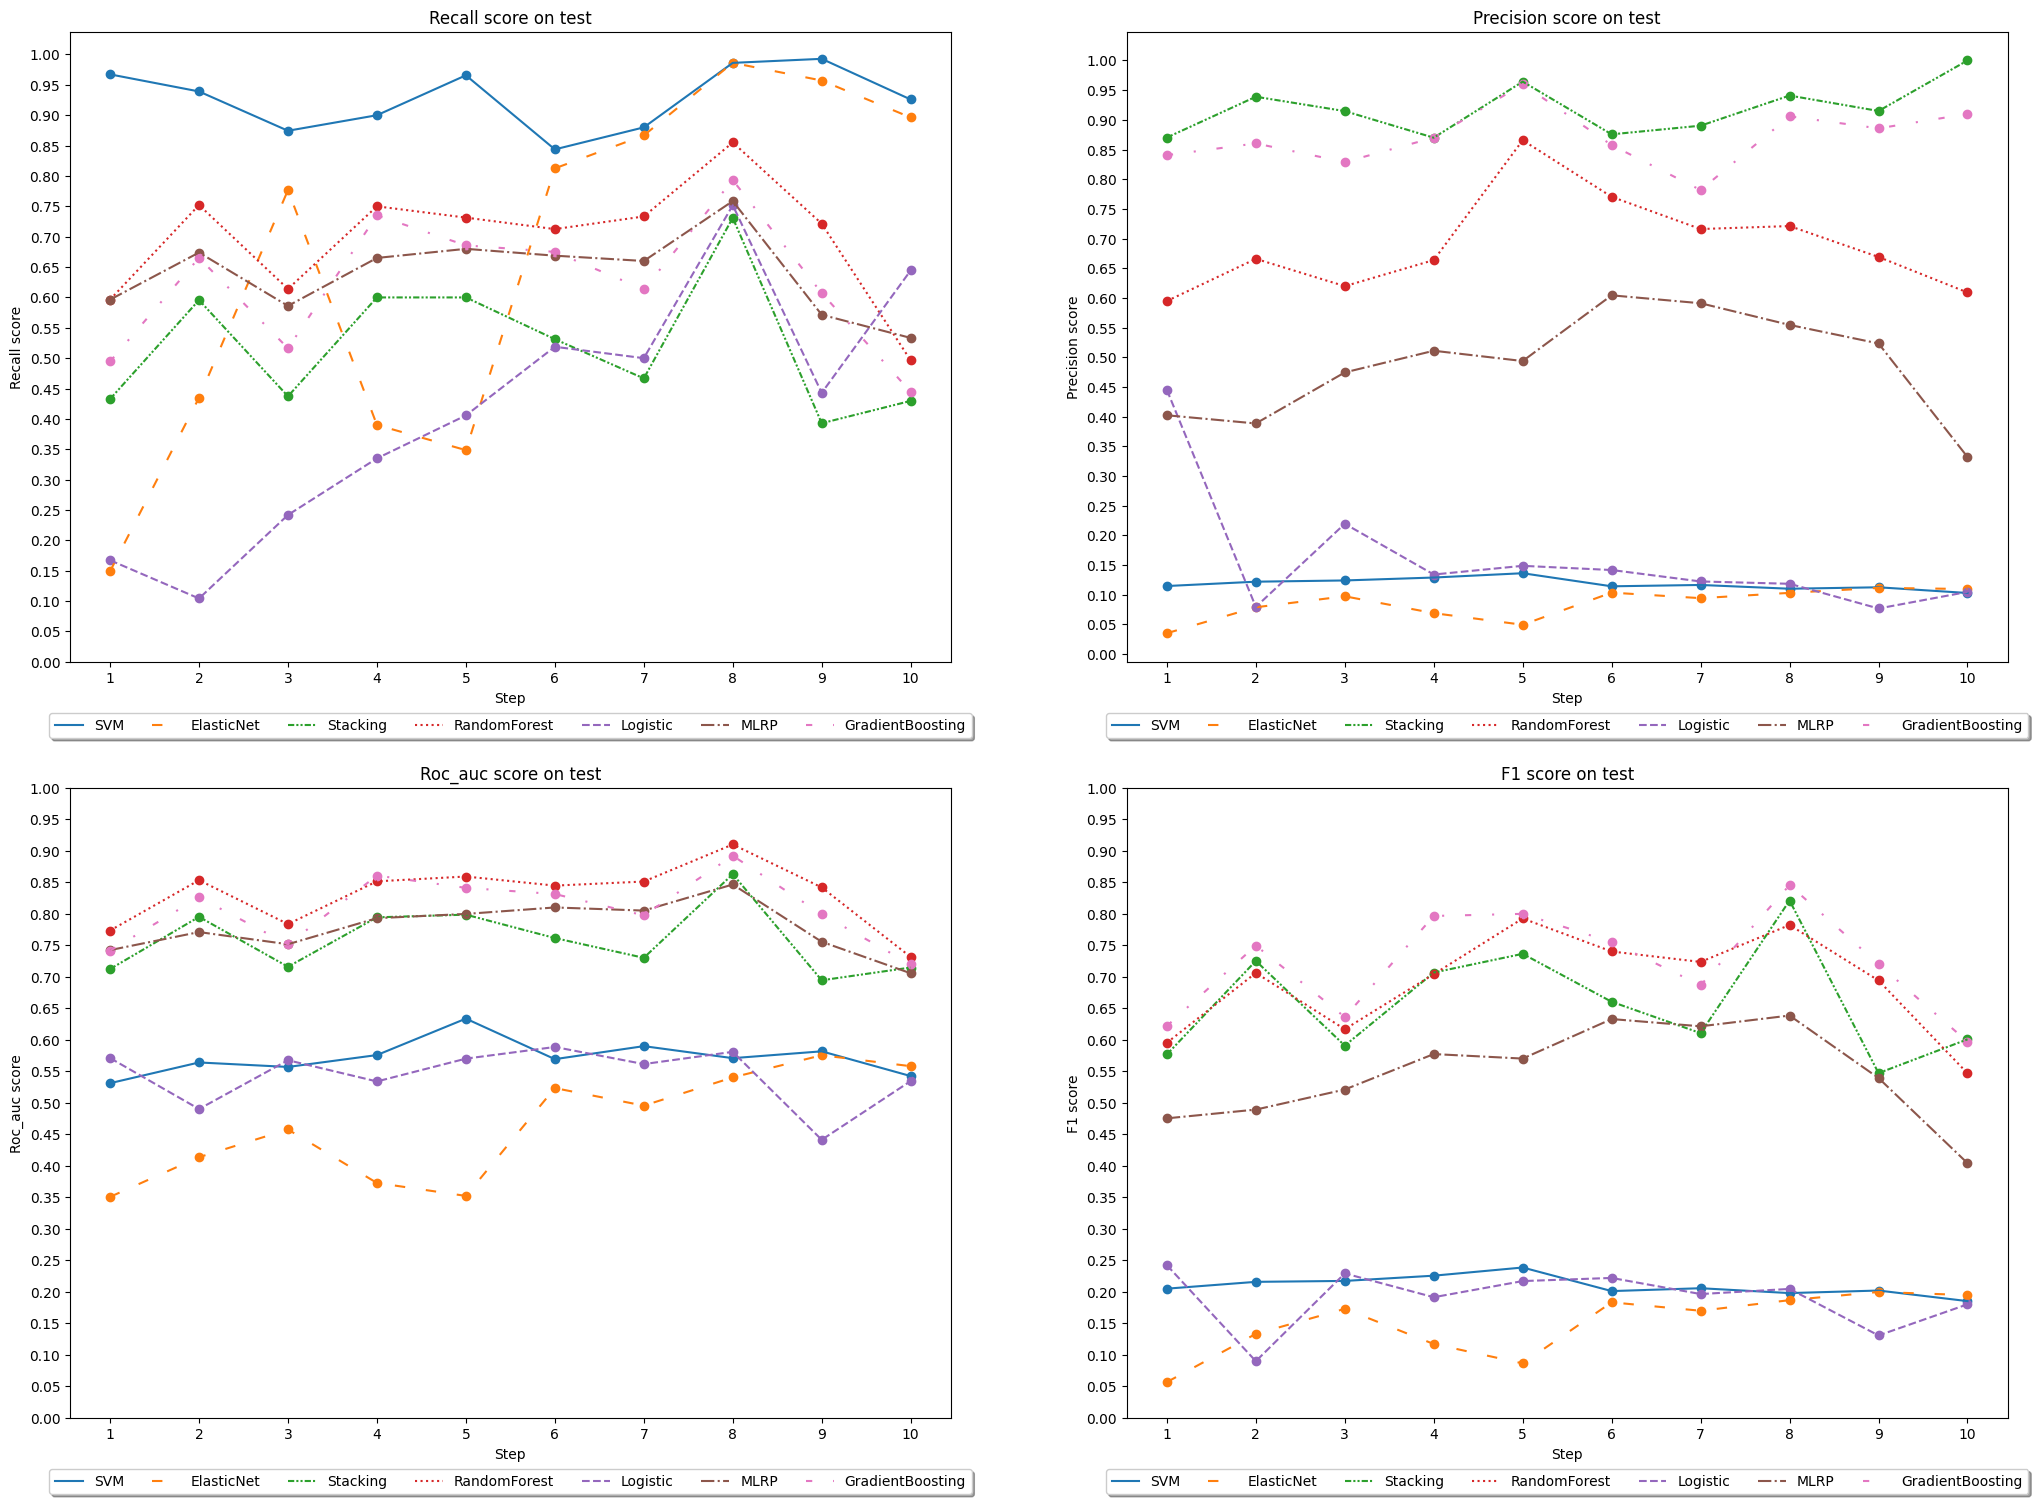

In [53]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(25,18))
axs = axs.ravel()
models = list(set(metrics_df['model']))
cols = metrics_df.columns[2:]
lines = ['-', (0, (5, 10)), (0, (3, 1, 1, 1, 1, 1)), ':', 'dashed', 'dashdot', (0, (3, 10, 1, 10))]
for i in range(len(axs)):
    ax=axs[i]
    col = cols[i]
    for j in range(len(models)):
        cur_model=models[j]
        temp_df = metrics_df[metrics_df['model']==cur_model][[col, 'step']]
        ax.plot(temp_df['step'],temp_df[col], label=cur_model, linestyle=lines[j])
        ax.scatter(x=temp_df['step'], y=temp_df[col])
    ax.set_xlabel('Step')
    ax.set_yticks(np.arange(0,1.05,0.05))
    ax.set_xticks(np.arange(1,11))
    col = col.capitalize()
    ax.set_title(f'{col} score on test')
    ax.set_ylabel(f'{col} score')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07),
          fancybox=True, shadow=True, ncol=7)
plt.show()

In [54]:
boosting_importances=pd.read_csv('Final_metrics_10_runs/boosting_importances_mean_random_oversampling.csv')
rf_importances=pd.read_csv('Final_metrics_10_runs/rf_importances_mean_random_oversampling.csv')
top15_boost=boosting_importances.groupby('Feature name')[['Feature importance']].sum().reset_index().sort_values('Feature importance', ascending=False).reset_index(drop=True).head(15)
top15_rf=rf_importances.groupby('Feature name')[['Feature importance']].sum().reset_index().sort_values('Feature importance', ascending=False).reset_index(drop=True).head(15)
top15_boost['Feature importance']/=top15_boost['Feature importance'].max()
top15_rf['Feature importance']/=top15_rf['Feature importance'].max()

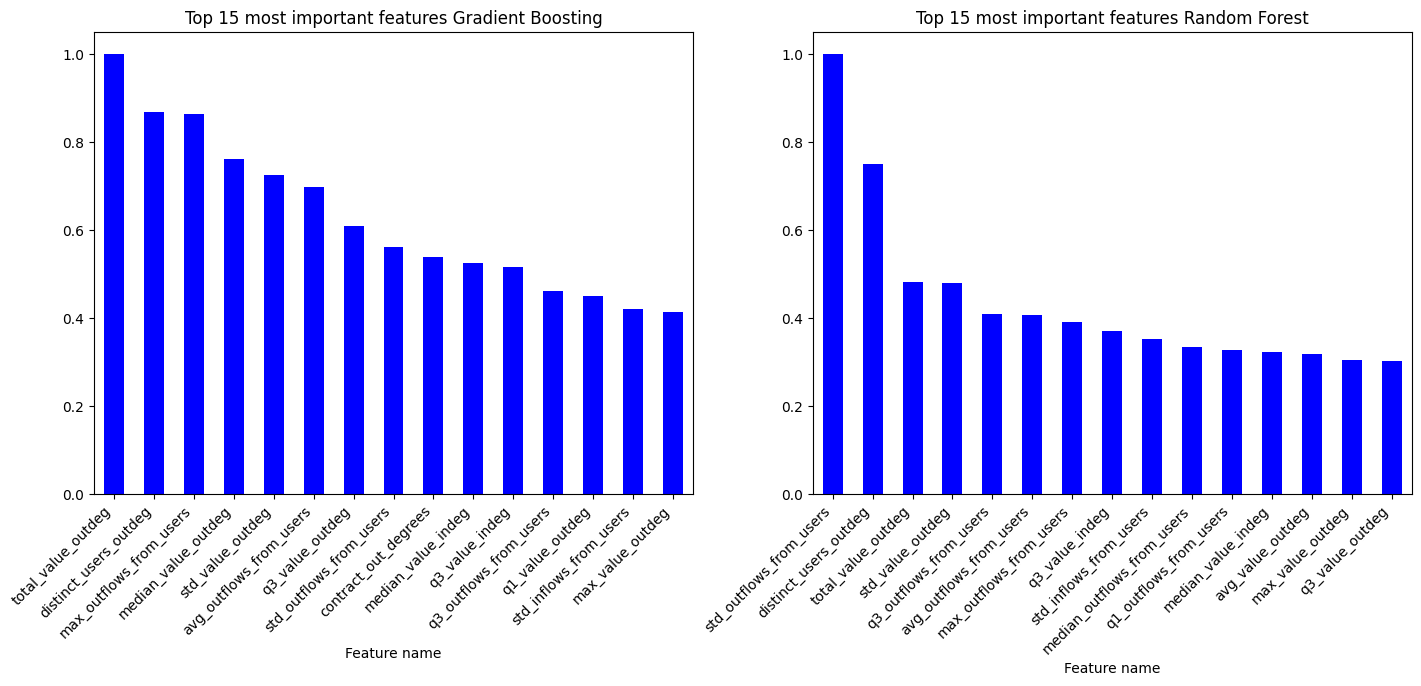

In [55]:
fig, axs = plt.subplots(ncols=2, figsize=(17,6))
ax=axs[0]
top15_boost.head(15).plot.bar(x='Feature name', y='Feature importance', color='blue', ax=ax)
ax.get_legend().remove()
ax.set_xticklabels(top15_boost.head(15)['Feature name'], rotation=45, ha='right')
ax.set_title('Top 15 most important features Gradient Boosting')
#RF
ax=axs[1]
top15_rf.head(15).plot.bar(x='Feature name', y='Feature importance', color='blue', ax=ax)
ax.get_legend().remove()
ax.set_xticklabels(top15_rf.head(15)['Feature name'], rotation=45, ha='right')
ax.set_title('Top 15 most important features Random Forest')
plt.show()


In [56]:
set(top15_boost['Feature name']).intersection(set(top15_rf['Feature name']))

{'avg_outflows_from_users',
 'distinct_users_outdeg',
 'max_outflows_from_users',
 'max_value_outdeg',
 'median_value_indeg',
 'q3_outflows_from_users',
 'q3_value_indeg',
 'q3_value_outdeg',
 'std_inflows_from_users',
 'std_outflows_from_users',
 'std_value_outdeg',
 'total_value_outdeg'}